# Simulating and Visualization Magic State Distillation (MSD)

*Yunzhe Zheng, for course project of APHY 526 (2024 Fall)*

## Why do we need MSD?
Quantum computers are regarded as promising platform to outperform classical computers on certain problems. However, real-world quantum computers are subject to various kind of quantum noise that could decohere quantum information and prevent us from gaining quantum advantages. Therefore, quantum computers must be made fault-tolerant in order to obtain robustness to quantum noise, and we need Quantum Error Correcting (QEC) codes to preserve quantum information in the logical qubits.

Although QEC codes allow to preserve quantum information in a fault-tolerant way, we would usually more like to process quantum information rather than just keep it in stationary memories. The quantum operation, surely, should also be fault-tolerant to avoid undesirable error propagation between different subsystems. A natural way to process quantum information is the so-called *transversal* operations, which means the logical operations are implemented by the physical operations implemeneted on each subsystem. For example, a logical CNOT gate between two logical qubits can be implemented by pair-wise physical CNOT gates between these two blocks:
<p align="center">
<img src="img/transversal.png" alt="drawing" width="200"/>
</p>

Transversality grants fault-tolerance naturally, as there won't be correlated errors cascaded from single local error. However, transversality is a too good property to be the golden solution for QEC. In 2009, Eastin and Knill proposed a no-go theorem, showing that no transversal gate sets can achieve universality in any QEC codes. Universal gate sets mean that we can implement arbitrary quantum computation with gates from the given gate sets, and universality has been considered to be a necessity for realistic quantum advantage. 

Clifford gates are these gate that maps Pauli operators to Pauli operators, and they can be generated by gate set $\{H, S, CNOT\}$. In many common codes, Clifford gate sets are transversal. Nevertheless, quantum circuits composed of only Clifford gates are also proved to be efficiently simulable with classical computers and bring no quantum advantages. Because of the no-go theorem, we therefore believe the non-Clifford resources are the *magic* ingredient from classical regime to quantum advantage.

Due to the fact that non-Clifford gates cannot be implemented transverally simultaneously with the Clifford gates, we usually believe that we must suffer a certain amount of noise when we apply logical non-Clifford gates. To circumvent this case, Bravyi and Kitaev proposed the *Magic State Distillation (MSD)* in 2005, which transfer the overhead for implementing high-quality non-Clifford gates to preparing high-fidelity non-Clifford states (or magic states) with a technique called gate injection. By consuming a high-fidelity copy of non-Clifford resource state, we can implemented a $T$ gate on the quantum circuit with only fault-tolerant operations.
<p align="center">
<img src="img/gate_injection.png" alt="drawing" width="400"/>
</p>

Therefore, as long as we have access to the high-fidelity magic states, we can achieve universal quantum computation together with fault-tolerant Clifford operations.



## What is MSD?
In MSD, we often start with a stable supply of moderate-fidelity magic states. We are aim to "distill" these raw states into higher fidelity states with only Clifford operations, measurements and classical processing. The process can somehow be regarded as an error-correcting process, but not exactly the same. Most MSD protocols can be described by stabilizer codes, and I will start by introducing the $[[5, 1, 3]]$ codes to show how we distill a faulty magic state into a better one.


### [[5, 1, 3]] MSD protocols

First, let us import some necessary modules. The `qiskit.quantum_info` module is a powerful module for analytically simulating quantum systems. We need `numpy` and `matplotlib.pyplot` as well for basic math and visualization. Please install these modules before running the notebook.

In [102]:
from qiskit import quantum_info as qi
import numpy as np
from matplotlib import pyplot as plt

The $[[5, 1, 3]]$ quantum code can be described by four stabilizer generators:

$$
S_1 = XZZXI, S_2 = IXZZX, S_3 = XIXZZ, S_4 = ZXIXZ.
$$
You might already noticed that $S_{2,3,4}$ can be obtained by cylic-shifting the qubit index in $S_1$. Actually, we can even shift more and have $S_5 = ZZXIX$. However, $S_5$ is not an independent stabilizer element as it can be described by
$$
S_5 = S_1S_2S_3S_4.
$$
Therefore, for full description of the code, four of the five cyclic symmetric elements will be sufficient.

Besides, the logical operators for the code can be defined by
$$
X_L = XXXXX, Z_L = ZZZZZ.
$$

Now, let's put the code description down. Thanks to `Pauli` in `qiskit.quantum_info`, we only need to input the Pauli strings.

In [103]:
generator_set = ['XZZXI', 'IXZZX', 'XIXZZ', 'ZXIXZ']
generator_set = [qi.Pauli(ele) for ele in generator_set]
logical_operator = {"X": "XXXXX", "Z": "ZZZZZ"}
logical_X = logical_operator['X']
logical_Z = logical_operator['Z']

We got the code! But how to distill magic states from it? As mentioned in this [paper](http://arxiv.org/abs/0908.0838), we must consider the stabilizer reduction protocols for MSD protocols. We need to define the codespace projector first. For stabilizer code $\mathcal{Q}$, the codespace projector is given by
$$
\bar{P} = \prod^{n-k}_{i=1}\frac{I+g_i}{2}.
$$

For the $[[5, 1, 3]]$ code, we have four generators. we can then calculate the codespace projector:

Text(0.5, 1.0, 'imag part')

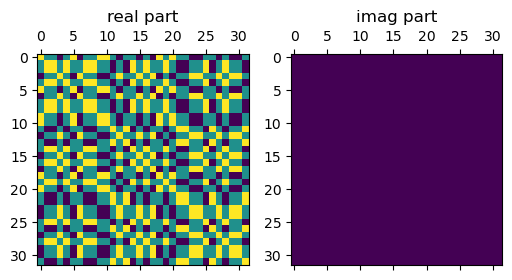

In [104]:
P_bar = np.eye(2**5)

for g in generator_set:
    P_bar = P_bar @ (g.to_matrix() + qi.Pauli('IIIII').to_matrix())/2

fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].matshow(P_bar.real)
axs[0].set_title('real part')
axs[1].matshow(P_bar.imag)
axs[1].set_title('imag part')


As we can see, the $\bar P$ is a full real matrix, which makes sense as a property for being a projector. We can further calculate the logical zero and logical one state by 

$$
\ket{0_L}\bra{0_L} = \frac{I+Z_L}{2}\bar{P}, \quad \ket{1_L} = X_L\ket{0_L}.
$$

We can use the build-in function `to_statevector` in `quantum_info` to get the statevector from density matrix.

In [105]:
logical_zero = qi.DensityMatrix(P_bar @ (qi.Pauli('IIIII').to_matrix() + qi.Pauli('ZZZZZ').to_matrix())/2).to_statevector()
logical_one = logical_zero.evolve(qi.Pauli('XXXXX'))

Finally, let's think about distillation! The magic state to be distilled is given by $\rho_{ideal} = (I+(X+Y+Z)/\sqrt{3})/2$. We consider the fully depolarizing noise model, where our raw input state is 

$$
\rho(\epsilon) = (1-2\epsilon)\rho_{ideal} + \epsilon I.
$$


In [106]:
rho_ideal = 0.5 * (qi.Pauli('I').to_matrix() + ( qi.Pauli('X').to_matrix() + qi.Pauli('Y').to_matrix() + qi.Pauli('Z').to_matrix())/np.sqrt(3) ) 

def get_single_rho(epsilon):
    return (1-2*epsilon)*rho_ideal + epsilon*np.eye(2)

The whole input state will be a tensor product of five single qubit state: $\rho_{in}=\rho(\epsilon)^{\otimes 5}$. The distillation is effectively to project the input state onto the codespace with the code projector $\bar{P}$:
$$
\rho_p \propto \bar{P} \rho_{in} \bar{P}
$$
and then decode with logical operators $X_L$ and $Z_L$. The output state will be
$$
\rho_o = (I+xX+yY+zZ)/2,
$$
with
$$
x = Tr [\bar{P}X_L \rho_p], \quad y = Tr [\bar{P}Y_L \rho_p], z = Tr [\bar{P}Z_L \rho_p]
$$

In [107]:
def projection_five(rho_input):
    p_suc = np.trace(P_bar @ rho_input)
    x = -np.trace(P_bar @ qi.Pauli(logical_operator['X']).to_matrix() @ rho_input)/p_suc
    y = np.trace(P_bar @ qi.Pauli(logical_operator['Z']).to_matrix() @ qi.Pauli(logical_operator['X']).to_matrix() @ rho_input * 1j)/p_suc
    z = -np.trace(P_bar @ qi.Pauli(logical_operator['Z']).to_matrix() @ rho_input)/p_suc
    #print(x, y, z)
    rho_output = 0.5 * (qi.Pauli('I').to_matrix() +  x*qi.Pauli('X').to_matrix() + y*qi.Pauli('Y').to_matrix() + z*qi.Pauli('Z').to_matrix() )
    fidelity = qi.state_fidelity(rho_output, rho_ideal)

    return p_suc, fidelity

In [108]:
e_list = np.arange(0,.5,.01)
e_out = []
psuc_list = []
for e in e_list:
    rho_single = get_single_rho(e)
    rho_five = rho_single
    for _ in range(4):
        rho_five = np.kron(rho_five, rho_single)
    p_suc, fidelity = projection_five(rho_five)
    e_out.append(1-fidelity)
    psuc_list.append(p_suc)

/opt/miniconda3/envs/magic_prep/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/magic_prep/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'success rate')

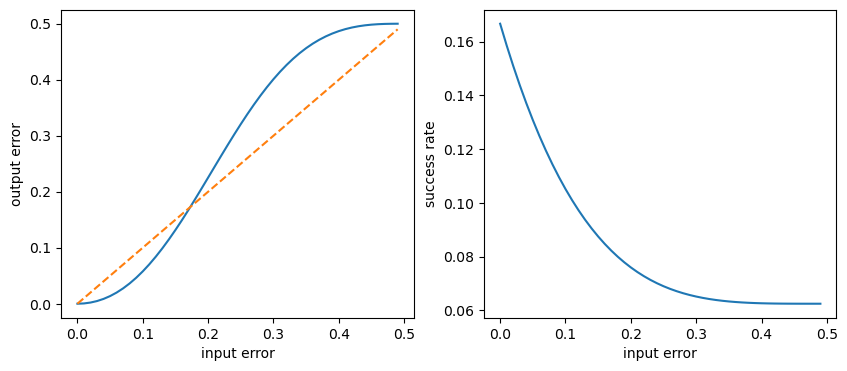

In [109]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(e_list,e_out)
axs[0].plot(e_list,e_list,'--')
axs[0].set_xlabel('input error')
axs[0].set_ylabel('output error')
axs[1].plot(e_list,psuc_list)
axs[1].set_xlabel('input error')
axs[1].set_ylabel('success rate')

Good! We have successfully simulated the MSD protocols based on $[[5, 1, 3]]$ code. Actually, this figure is exactly the same as the result in the first very paper back in 2005 [here](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.71.022316). When the input error is small, the output error is suppressed quadraticaly as $\epsilon_o = 5 \epsilon^2_i$. However, the protocol is not deterministic. Even if we input perfect state into the protocol, we can only succeed with $1/6$ probability.

Now let's examine more examples. We consider the $[[7, 1, 3]]$ Steane code, which is the smallest CSS code that is able to correct a sinlge quantum error. CSS code means the stabilizer codes has separate $X$ check and $Z$ check. This kind of codes allows for transversal CNOT and can be decoded more easily, therefore becomes a reserach focus for near-term QEC community.

### [[7, 1, 3]] code

First, let's define the code. Consider the classical $[7, 4, 3]$ Hamming code check matrix

$$
\begin{bmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 1 & 1 & 0\\
1 & 0 & 1 & 0 & 1 & 0 & 1\\
\end{bmatrix}
$$
Both the X and Z check of the Steane code is the same for the check matrix. Further, we can define the logical operator. For Steane code, $X_L = XXXXXXX, Z_L = ZZZZZZZ$.

In [110]:
generator_set = ['XXXXIII', 'XXIIXXI', 'XIXIXIX', 'ZZZZIII','ZZIIZZI','ZIZIZIZ']
generator_set = [qi.Pauli(ele) for ele in generator_set]
logical_operator = {"X": "XXXXXXX", "Z": "ZZZZZZZ"}
logical_X = logical_operator['X']
logical_Z = logical_operator['Z']

This code can be used to distill the famous $\ket{T}\propto \ket{0}+e^{i\pi/4}\ket{1}$ state. Now, let's repeat the procedure for the $[[5, 1, 3]]$ code and try to plot the similar output-input error figure as above:

In [111]:
P_bar = np.eye(2**7)
for g in generator_set:
    P_bar = P_bar @ (g.to_matrix() + qi.Pauli('IIIIIII').to_matrix())/2

logical_zero = qi.DensityMatrix(P_bar @ (qi.Pauli('IIIIIII').to_matrix() + qi.Pauli(logical_Z).to_matrix())/2).to_statevector()
logical_one = logical_zero.evolve(qi.Pauli(logical_X))

rho_ideal = 0.5 * (qi.Pauli('I').to_matrix() + ( qi.Pauli('X').to_matrix() + qi.Pauli('Z').to_matrix())/np.sqrt(2) ) 
def get_single_rho(epsilon):
    return (1-2*epsilon)*rho_ideal + epsilon*np.eye(2)

def projection_seven(rho_input):
    p_suc = np.trace(P_bar @ rho_input)
    x = np.trace(P_bar @ qi.Pauli(logical_operator['X']).to_matrix() @ rho_input)/p_suc
    y = np.trace(P_bar @ qi.Pauli(logical_operator['Z']).to_matrix() @ qi.Pauli(logical_operator['X']).to_matrix() @ rho_input * 1j)/p_suc
    z = np.trace(P_bar @ qi.Pauli(logical_operator['Z']).to_matrix() @ rho_input)/p_suc
    #print(x, y, z)
    rho_output = 0.5 * (qi.Pauli('I').to_matrix() +  x*qi.Pauli('X').to_matrix() + y*qi.Pauli('Y').to_matrix() + z*qi.Pauli('Z').to_matrix() )
    fidelity = qi.state_fidelity(rho_output, rho_ideal)

    return p_suc, fidelity

e_list = np.arange(0,.5,.01)
e_out = []
psuc_list = []
for e in e_list:
    rho_single = get_single_rho(e)
    rho_seven = rho_single
    for _ in range(6):
        rho_seven = np.kron(rho_seven, rho_single)
    p_suc, fidelity = projection_seven(rho_seven)
    e_out.append(1-fidelity)
    psuc_list.append(p_suc)

Text(0, 0.5, 'success rate')

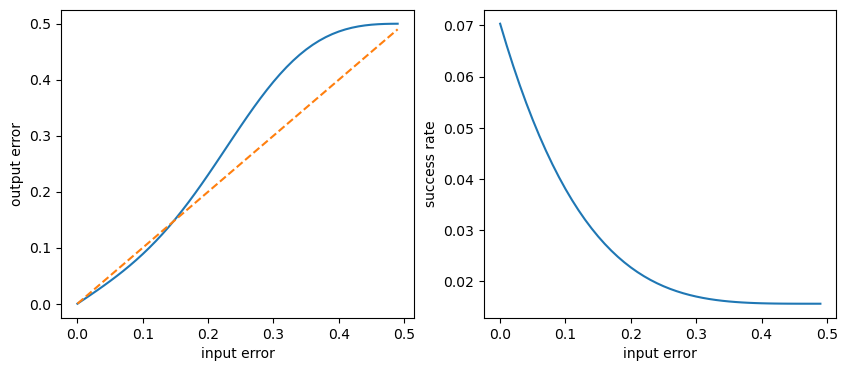

In [112]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(e_list,e_out)
axs[0].plot(e_list,e_list,'--')
axs[0].set_xlabel('input error')
axs[0].set_ylabel('output error')
axs[1].plot(e_list,psuc_list)
axs[1].set_xlabel('input error')
axs[1].set_ylabel('success rate')

Coool! And we reproduced the result from another paper from Ben Reichardt [Quantum Universality from Magic States Distillation Applied to CSS Codes
](https://link.springer.com/article/10.1007/s11128-005-7654-8). Unfortunately, this protocol performs worse than the previous $[[5, 1, 3]]$ protocol in terms of the efficiency. The error suppression now is only linear with $\epsilon_o = 7\epsilon_i/9$, and the success rate with ideal input is only $9/128$!

In principle, we would like MSD protocols with high-order error suppression, and it would be better if they can be done deterministically with perfect input. Therefore, we have to consider more complicated protocols: The $[[15, 1, 3]]$ quantum Reed-Muller code.

### [[15, 1, 3]] code

Let's describe the code first. The code has 4 X-type stabilizers and 10 Z-type stabilizers.

In [113]:
Gx = np.array(
           [[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
            [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]]
)

Gz = np.array(
           [[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
            [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
            [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]]
)

G_qi = []
for gz in Gz:
    pauli_string = ''.join(['Z' if ele==1 else 'I' for ele in gz])
    G_qi.append(qi.Pauli(pauli_string))
for gx in Gx:
    pauli_string = ''.join(['X' if ele==1 else 'I' for ele in gx])
    G_qi.append(qi.Pauli(pauli_string))

X_L = qi.Pauli('X'*15)
Z_L = qi.Pauli('Z'*15)
Y_L = qi.Pauli('-i'+'Y'*15)

generator_set = [G.to_label() for G in G_qi]
logical_operator = {'Z':Z_L.to_label(),'X':X_L.to_label()}

Wait, now the code has 15 qubits, so it might be hard to simulate them directly using the matrix way. Or you have to calculate square matrix with dimension $2^{15}=32768$! You can try, but I can guarantee that your waiting time will be annoying.

What can we do then? In the very [first paper](https://doi.org/10.1103%2FPhysRevA.71.022316), the author assumed particular noise channel and did some analytical derivative to get the input-output error relation. You are welcome to rewalk their path, but I will tell you a more interesting method to obtain it.

## Mapping MSD to dynamic systems

In my incoming work to be appeared in arXiv, I find that MSD protocols can actually be mapped to dynamic systems, which allows us to easily simulate and visualize MSD protocols.



### From Stabilizer Reduction to Analytical Form

As we discussed above, the process of MSD can be understood as a projection to the codespace. Besides, any single-qubit quantum states can be described with Bloch coordinate:

$$
\rho(x,y,z) = (I+xX+yY+zZ)/2
$$

If we assume identical tensor product of input state, the whole input state for a MSD protocol will be

$$
\rho_{in}(x,y,z) = \rho(x,y,z)^{\otimes n}
$$

For single-output MSD protocols , our output state is given by:
\begin{equation}
    \begin{cases}
        x^o = Tr[\rho_{p}\bar{X}] = Tr[P_\mathcal{Q}\rho_{in}\bar{X}]/p_s\\
        y^o = Tr[\rho_{p}\bar{Y}] = Tr[P_\mathcal{Q}\rho_{in}\bar{Y}]/p_s\\
        z^o = Tr[\rho_{p}\bar{Z}] = Tr[P_\mathcal{Q}\rho_{in}\bar{Z}]/p_s,
    \end{cases}
\end{equation}
As the output (x,y,z) is a function of the input (x,y,z), we can actually have it as a dynamic system of (x,y,z), which is supposed to be within the Bloch sphere for valid quantum states. For covenience, we now define 
$$
Tr[P_\mathcal{Q}\rho_{in}\bar{X}]/p_s = T_x, \quad Tr[P_\mathcal{Q}\rho_{in}\bar{Y}]/p_s = T_y, \quad Tr[P_\mathcal{Q}\rho_{in}\bar{Z}]/p_s = T_z.
$$
As long as we can calculate the analytical expression of $p_s, T_{x,y,z}$, we would then obtain the analytical expression of our mapped dynamic system.

Without diving too deeply, I will outline the core idea for calculating the analytical expression here. The core observation is to realize the codespace projector can be written as a sum of Pauli operator 
$$
\bar{P} = \prod^{n-k}_{i=1}\frac{I+g_i}{2} = \frac{1}{2^{n-k}}\sum^{2^{n-k}}_{j=1}s_j.
$$
Due to the linear property of trace, we can expand the codespace projector out and calculate the trace of $\rho_{in}$ for each term $s_j$. Importantly, $s_j$ is a tensor poduct of Pauli $I,X,Y,Z$, and $\rho_{in}$ is a tensor product of identical single-qubit states. As 
$$
Tr[\rho(x,y,z)X]=x, Tr[\rho(x,y,z)Y]=y, Tr[\rho(x,y,z)Z]=z,
$$
each term $s_j$ will correspond to a polynomial term $ x^{w_{xj}} y^{w_{yj}} z^{w{zj}}$, where $w_{xj}, w_{yj}, w_{zj}$ are all the weight of $X,Y,Z$ in $s_j$. Therefore, we only need to count the Pauli weight in the whole stabilizer group for each $s_j$, sum them together, and we will get the dynamic system of the mapped protocols.

I wrapped this calculation with my predefined function `get_poly_from_code`, which counts the Pauli weight taking input stabilizer codes, and `poly_dicts_to_sympy`, which converts the counted information to the `sympy` expression. Now let's show how to obtain the dynamic system for the $[[15, 1, 3]]$ MSD protocol.

### Simulating [[15, 1, 3]] with dynamic systems


In [114]:
import sympy as sp
from utils import get_poly_from_code, poly_dicts_to_sympy

poly_dicts = get_poly_from_code(generator_set=generator_set, logical_operator=logical_operator)
psuc_sp, Tx_sp, Ty_sp, Tz_sp = poly_dicts_to_sympy(poly_dicts)

Let's take a look at them:

In [115]:
psuc_sp

105*x**8*z**4 + 15*x**8 - 420*x**6*y**2*z**6 - 1680*x**6*y**2*z**4 - 1260*x**6*y**2*z**2 + 840*x**4*y**4*z**6 + 4830*x**4*y**4*z**4 + 2520*x**4*y**4*z**2 + 210*x**4*y**4 - 420*x**2*y**6*z**6 - 1680*x**2*y**6*z**4 - 1260*x**2*y**6*z**2 + 105*y**8*z**4 + 15*y**8 + 35*z**12 + 168*z**10 + 435*z**8 + 280*z**6 + 105*z**4 + 1

In [116]:
Tx_sp

(x**15 + 105*x**11*y**4 - 280*x**9*y**6 + 435*x**7*y**8 + 15*x**7*z**8 + 210*x**7*z**4 + 15*x**7 - 168*x**5*y**10 - 1260*x**5*y**2*z**6 - 2520*x**5*y**2*z**4 - 1260*x**5*y**2*z**2 + 35*x**3*y**12 + 105*x**3*y**4*z**8 + 1680*x**3*y**4*z**6 + 4830*x**3*y**4*z**4 + 1680*x**3*y**4*z**2 + 105*x**3*y**4 - 420*x*y**6*z**6 - 840*x*y**6*z**4 - 420*x*y**6*z**2)/(105*x**8*z**4 + 15*x**8 - 420*x**6*y**2*z**6 - 1680*x**6*y**2*z**4 - 1260*x**6*y**2*z**2 + 840*x**4*y**4*z**6 + 4830*x**4*y**4*z**4 + 2520*x**4*y**4*z**2 + 210*x**4*y**4 - 420*x**2*y**6*z**6 - 1680*x**2*y**6*z**4 - 1260*x**2*y**6*z**2 + 105*y**8*z**4 + 15*y**8 + 35*z**12 + 168*z**10 + 435*z**8 + 280*z**6 + 105*z**4 + 1)

In [117]:
Ty_sp

(35*x**12*y**3 - 168*x**10*y**5 + 435*x**8*y**7 - 280*x**6*y**9 - 420*x**6*y*z**6 - 840*x**6*y*z**4 - 420*x**6*y*z**2 + 105*x**4*y**11 + 105*x**4*y**3*z**8 + 1680*x**4*y**3*z**6 + 4830*x**4*y**3*z**4 + 1680*x**4*y**3*z**2 + 105*x**4*y**3 - 1260*x**2*y**5*z**6 - 2520*x**2*y**5*z**4 - 1260*x**2*y**5*z**2 + y**15 + 15*y**7*z**8 + 210*y**7*z**4 + 15*y**7)/(105*x**8*z**4 + 15*x**8 - 420*x**6*y**2*z**6 - 1680*x**6*y**2*z**4 - 1260*x**6*y**2*z**2 + 840*x**4*y**4*z**6 + 4830*x**4*y**4*z**4 + 2520*x**4*y**4*z**2 + 210*x**4*y**4 - 420*x**2*y**6*z**6 - 1680*x**2*y**6*z**4 - 1260*x**2*y**6*z**2 + 105*y**8*z**4 + 15*y**8 + 35*z**12 + 168*z**10 + 435*z**8 + 280*z**6 + 105*z**4 + 1)

In [118]:
Tz_sp

(15*x**8*z**7 + 105*x**8*z**3 - 1260*x**6*y**2*z**5 - 1680*x**6*y**2*z**3 - 420*x**6*y**2*z + 210*x**4*y**4*z**7 + 2520*x**4*y**4*z**5 + 4830*x**4*y**4*z**3 + 840*x**4*y**4*z - 1260*x**2*y**6*z**5 - 1680*x**2*y**6*z**3 - 420*x**2*y**6*z + 15*y**8*z**7 + 105*y**8*z**3 + z**15 + 105*z**11 + 280*z**9 + 435*z**7 + 168*z**5 + 35*z**3)/(105*x**8*z**4 + 15*x**8 - 420*x**6*y**2*z**6 - 1680*x**6*y**2*z**4 - 1260*x**6*y**2*z**2 + 840*x**4*y**4*z**6 + 4830*x**4*y**4*z**4 + 2520*x**4*y**4*z**2 + 210*x**4*y**4 - 420*x**2*y**6*z**6 - 1680*x**2*y**6*z**4 - 1260*x**2*y**6*z**2 + 105*y**8*z**4 + 15*y**8 + 35*z**12 + 168*z**10 + 435*z**8 + 280*z**6 + 105*z**4 + 1)

OMG, this is too complicated! Luckily, we may reduce the system to the $xy$ plane by setting $y=0$ as our target state $\ket{T}$ state can be chosen on the $xz$ plane.

In [119]:
x, y, z = sp.symbols("x y z", real=True)

psuc_sp = psuc_sp.subs({z:0})
Tx_sp = Tx_sp.subs({z:0})
Ty_sp = Ty_sp.subs({z:0})
Tz_sp = Tz_sp.subs({z:0})


In [120]:
psuc_sp

15*x**8 + 210*x**4*y**4 + 15*y**8 + 1

In [121]:
Tx_sp

(x**15 + 105*x**11*y**4 - 280*x**9*y**6 + 435*x**7*y**8 + 15*x**7 - 168*x**5*y**10 + 35*x**3*y**12 + 105*x**3*y**4)/(15*x**8 + 210*x**4*y**4 + 15*y**8 + 1)

In [122]:
Ty_sp

(35*x**12*y**3 - 168*x**10*y**5 + 435*x**8*y**7 - 280*x**6*y**9 + 105*x**4*y**11 + 105*x**4*y**3 + y**15 + 15*y**7)/(15*x**8 + 210*x**4*y**4 + 15*y**8 + 1)

In [123]:
Tz_sp

0

Now the expression is much cleaner and $T_z$ also becomes zero! Let's then plot the flow diagram.

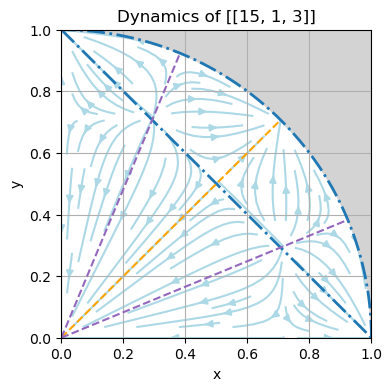

In [124]:
Tx = sp.lambdify(['x','y'], Tx_sp)
Ty = sp.lambdify(['x','y'], Ty_sp)

def vector_field(x,y):
    x_out, y_out = Tx(x,y), Ty(x,y)
    return x_out-x, y_out-y


x=np.linspace(0,1,50)
y=np.linspace(0,1,50)
X, Y = np.meshgrid(x, y)
U, V = vector_field(X, Y)

fig, ax = plt.subplots(figsize=(4,4))
ax.streamplot(X, Y, U, V, broken_streamlines=True, color='lightblue',zorder=0)
t=np.linspace(0,np.pi/2, 1000)
ax.plot(np.cos(t),np.sin(t),'-.',linewidth=2,color='C0')
ax.plot(np.linspace(0,1,100), 1-np.linspace(0,1,100),'-.',linewidth=2, color='C0')
ax.fill_between(np.linspace(0, 1, 100), [np.sqrt(1-x**2) for x in np.linspace(0, 1, 100)], 1, interpolate=False,color='lightgrey')
ax.plot(np.linspace(0,1/np.sqrt(2),100), np.linspace(0,1/np.sqrt(2),100),'--',color='orange')
plt.plot(np.linspace(0,np.cos(np.pi/8),100), np.linspace(0,np.sin(np.pi/8),100),'--', color='C4')
plt.plot(np.linspace(0,np.cos(np.pi*3/8),100), np.linspace(0,np.sin(np.pi*3/8),100),'--', color='C4')
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_title('β=1')
ax.set_title('Dynamics of [[15, 1, 3]]')
ax.axhline(0, color='black',linewidth=0.5)
ax.axvline(0, color='black',linewidth=0.5)
plt.ylim([0, 1])
plt.xlim([0, 1])
ax.grid()


Beautiful flow! So basically, the arrow in the flow diagram shows how an input state will flow to within the Bloch sphere. We see several attractors on the boundary, which corresponds to the magic states we are distilling into. Particularly, we have the $\ket{T}$ state (range) as well as the $\ket{\sqrt{T}}$ states (purple)! This is really interesting, as people previously believe the $\sqrt{T}$ gate is harder to implement and $[[15, 1, 3]]$ cannot prepare the magic states. Now let's look into the input-output relation with our dynamic system:

Text(0.5, 1.0, '[[15, 1, 3]]')

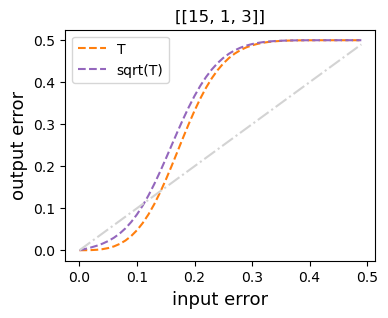

In [125]:
e_list = np.arange(0,0.5,0.01)
e_out_list = []
e_out_eight = []
for e in e_list:
    x_input, y_input = 1/np.sqrt(2)*(1-2*e), 1/np.sqrt(2)*(1-2*e)
    x_out = Tx(x_input, y_input)
    y_out = Ty(x_input, y_input)

    e_out = (1 - (x_out+y_out) * 1/np.sqrt(2)) * 0.5
    e_out_list.append(e_out)

    x_input, y_input = np.cos(np.pi/8)*(1-2*e), np.sin(np.pi/8)*(1-2*e)
    x_out = Tx(x_input, y_input)
    y_out = Ty(x_input, y_input)

    e_out_eight.append((1 - x_out * np.cos(np.pi/8) - y_out * np.sin(np.pi/8)) * 0.5)

plt.subplots(figsize=(4,3))
plt.plot(e_list, e_out_list,'--',color='C1',label='T')
plt.plot(e_list, e_out_eight,'--',color='C4',label='sqrt(T)')
plt.plot(e_list, e_list,'-.',color='lightgrey')
plt.legend()
plt.xlabel('input error',fontsize=13)
plt.ylabel('output error',fontsize=13)
plt.title('[[15, 1, 3]]')

Fabulous! This orange curve is actually the figure presented in the last half part of [here](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.71.022316), and the purple curve is brand new and goona appear in my incoming work. You might also realized that the ploting of this figure is instant in your own computer: Yes, this way simulates MSD protocls much faster than the matrix method. The main algorithmatic complexity comes from the exponential number of stabilizer elements, but we only need to count the number of `X` `Y` `Z` in them without doing the complicated matrix multiplication. Therefore, our algorithm is more efficient. You might wonder if we can even get rid of the exponential cost in our complexity, but that seems to be infeasible, as stabilizer code is inherently hard to simulate and there has been many no-go theorems that implying there cannot be polynomial algorithm to simulate stabilizer codes.

### Bonus: Plot the flow diagram for $[[7, 1, 3]]$ code.

Now I will give some challenges to you readers. I have all code blocks you need to plot the flow diagram for the Steane code. Try it on yourself!(Actually, just put the description of the code and you are done!)

Text(0.5, 1.0, '[[7, 1, 3]]')

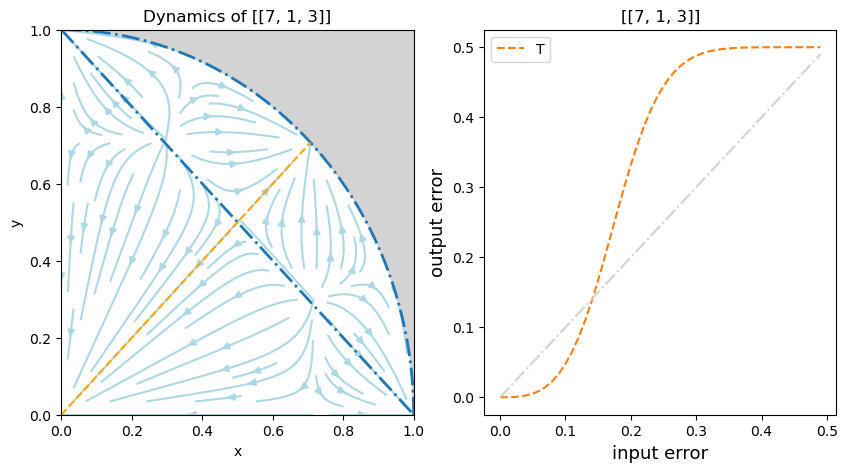

In [126]:
## Input your generator_set and logical_operator

## generator_set = 
## logical_operator = 


poly_dicts = get_poly_from_code(generator_set=generator_set, logical_operator=logical_operator)
psuc_sp, Tx_sp, Ty_sp, Tz_sp = poly_dicts_to_sympy(poly_dicts)
x, y, z = sp.symbols("x y z", real=True)
psuc_sp = psuc_sp.subs({z:0})
Tx_sp = Tx_sp.subs({z:0})
Ty_sp = Ty_sp.subs({z:0})
Tz_sp = Tz_sp.subs({z:0})
Tx = sp.lambdify(['x','y'], Tx_sp)
Ty = sp.lambdify(['x','y'], Ty_sp)

def vector_field(x,y):
    x_out, y_out = Tx(x,y), Ty(x,y)
    return x_out-x, y_out-y


x=np.linspace(0,1,50)
y=np.linspace(0,1,50)
X, Y = np.meshgrid(x, y)
U, V = vector_field(X, Y)


e_list = np.arange(0,0.5,0.01)
e_out_list = []
for e in e_list:
    x_input, y_input = 1/np.sqrt(2)*(1-2*e), 1/np.sqrt(2)*(1-2*e)
    x_out = Tx(x_input, y_input)
    y_out = Ty(x_input, y_input)

    e_out = (1 - (x_out+y_out) * 1/np.sqrt(2)) * 0.5
    e_out_list.append(e_out)


fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].streamplot(X, Y, U, V, broken_streamlines=True, color='lightblue',zorder=0)
t=np.linspace(0,np.pi/2, 1000)
axs[0].plot(np.cos(t),np.sin(t),'-.',linewidth=2,color='C0')
axs[0].plot(np.linspace(0,1,100), 1-np.linspace(0,1,100),'-.',linewidth=2, color='C0')
axs[0].fill_between(np.linspace(0, 1, 100), [np.sqrt(1-x**2) for x in np.linspace(0, 1, 100)], 1, interpolate=False,color='lightgrey')
axs[0].plot(np.linspace(0,1/np.sqrt(2),100), np.linspace(0,1/np.sqrt(2),100),'--',color='orange')

axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Dynamics of [[7, 1, 3]]')
axs[0].axhline(0, color='black',linewidth=0.5)
axs[0].axvline(0, color='black',linewidth=0.5)
axs[0].set_ylim([0, 1])
axs[0].set_xlim([0, 1])
ax.grid()

axs[1].plot(e_list, e_out_list,'--',color='C1',label='T')
axs[1].plot(e_list, e_list,'-.',color='lightgrey')
axs[1].legend()
axs[1].set_xlabel('input error',fontsize=13)
axs[1].set_ylabel('output error',fontsize=13)
axs[1].set_title('[[7, 1, 3]]')


What have you got? Compare it with the figure in the cheat sheet. Now you are a master of MSD protocols. Stay tuned with my incoming paper to be on arxiv, and feel free to let me know if you are interested in developing more about MSD!